In [60]:
import numpy as np
import rgrow as rg
import matplotlib.pyplot as plt

We can initially define our XOR system through the tileset interface, running it in the aTAM:

In [2]:
tileset = rg.TileSet(
    [
        rg.Tile(name="S", edges=["null", "rb", "bb", "null"], color="purple", stoic=0),
        rg.Tile(name="RB", edges=["null", "rb", "e1", "rb"], color="red"),
        rg.Tile(name="BB", edges= ["bb", "e1", "bb", "null"], color="blue"),
        rg.Tile(name="00", edges= ["e0", "e0", "e0", "e0"], color="teal"),
        rg.Tile(name="10", edges= ["e1", "e1", "e1", "e0"], color="green"),
        rg.Tile(name="01", edges= ["e0", "e1", "e1", "e1"], color="yellow"),
        rg.Tile(name="11", edges= ["e1", "e0", "e0", "e1"], color="orange"),
    ],
    bonds=[rg.Bond("rb", 2), rg.Bond("bb", 2)],
    seed=[
        (0, 0, "S")
    ],
    model="aTAM",
    size=(16,16),
    canvas_type="SquareCompact",
)

In [3]:
system, state = tileset.create_system_and_state()

In [4]:
system.evolve(state, for_events=16*16-1)

EvolveOutcome.ReachedEventsMax

<Axes: >

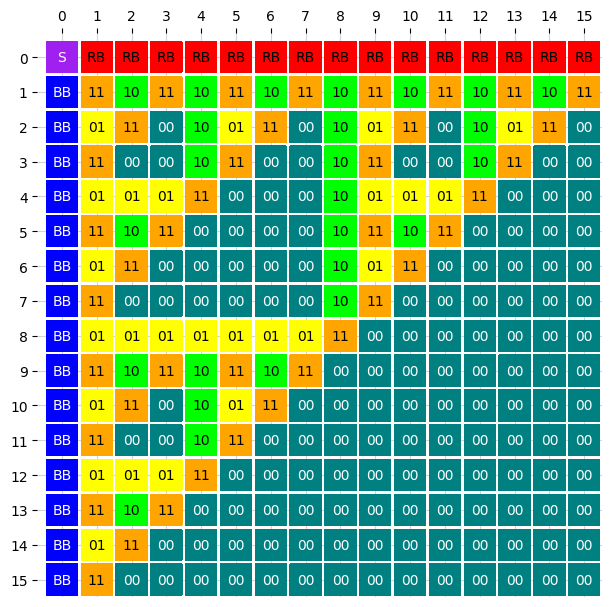

In [6]:
system.plot_canvas(state, annotate_tiles=True)

Now let's take the tileset and use the kTAM instead:

In [35]:
tileset.model = "kTAM"
tileset.gmc = 16
tileset.gse = 9

<Axes: >

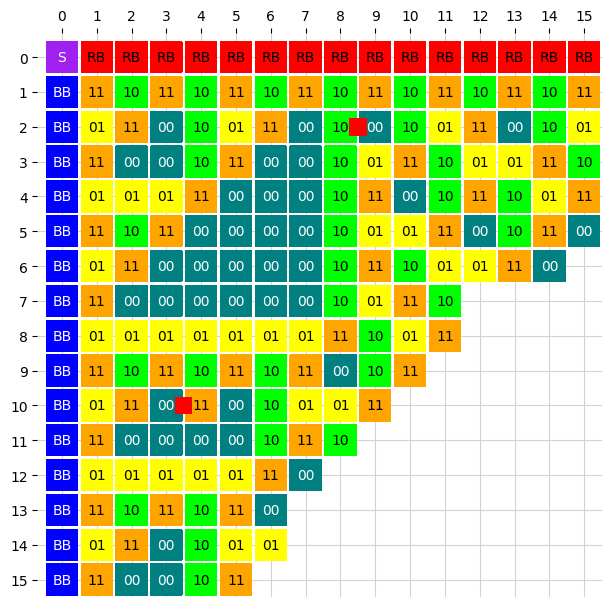

In [36]:
system, state = tileset.create_system_and_state()
system.evolve(state, for_time=300)
system.plot_canvas(state, annotate_tiles=True, annotate_mismatches=True)

Perhaps we want to get an error rate, and want to use many simulations to do that, at a larger scale:

In [71]:
tileset.size = (32, 32)

gses = [8.6, 8.8, 9.0, 9.2, 9.4, 10.0, 10.5, 11.0, 11.5, 12.0]

error_rates = []
times = []
error_rate_cis = []
times_cis = []

for gse in gses:
    tileset.gse = gse
    system = tileset.create_system()
    states = [tileset.create_state() for _ in range(100)]
    # total time ensures the simulation eventually ends
    outcomes = system.evolve(states, size_max=32*32//2, total_time=1e7) 
    assert all( outcome == rg.EvolveOutcome.ReachedSizeMax for outcome in outcomes )

    error_rate_vals = np.array([system.calc_mismatches(state)/state.n_tiles for state in states])
    time_vals = np.array([state.time for state in states])

    error_rate = np.mean(error_rate_vals)
    time = np.mean(time_vals)

    error_rate_ci = np.percentile(error_rate_vals, [5, 95])
    speed_ci = np.percentile(time_vals, [5, 95])

    error_rates.append(error_rate)
    times.append(time)
    error_rate_cis.append(error_rate_ci)
    times_cis.append(speed_ci)
    
    print(f"gse={gse:.1f}: error_rate={error_rate:.3f} (95% CI: {error_rate_ci[0]:.3f}, {error_rate_ci[1]:.3f}), time={time:.3f} (95% CI: {times_cis[-1][0]:.3f}, {times_cis[-1][1]:.3f})")

gse=8.6: error_rate=0.004 (95% CI: 0.000, 0.008), time=598.291 (95% CI: 525.502, 669.197)
gse=8.8: error_rate=0.005 (95% CI: 0.000, 0.012), time=531.778 (95% CI: 471.867, 603.298)
gse=9.0: error_rate=0.005 (95% CI: 0.000, 0.012), time=489.039 (95% CI: 437.939, 540.833)
gse=9.2: error_rate=0.007 (95% CI: 0.002, 0.012), time=466.137 (95% CI: 429.367, 521.290)
gse=9.4: error_rate=0.009 (95% CI: 0.004, 0.018), time=457.929 (95% CI: 409.764, 514.950)
gse=10.0: error_rate=0.015 (95% CI: 0.008, 0.025), time=423.993 (95% CI: 380.395, 471.653)
gse=10.5: error_rate=0.025 (95% CI: 0.016, 0.035), time=408.751 (95% CI: 370.695, 445.835)
gse=11.0: error_rate=0.038 (95% CI: 0.023, 0.057), time=392.390 (95% CI: 356.130, 437.168)
gse=11.5: error_rate=0.057 (95% CI: 0.037, 0.078), time=360.792 (95% CI: 330.291, 397.451)
gse=12.0: error_rate=0.088 (95% CI: 0.068, 0.125), time=340.431 (95% CI: 297.899, 385.660)


<ErrorbarContainer object of 3 artists>

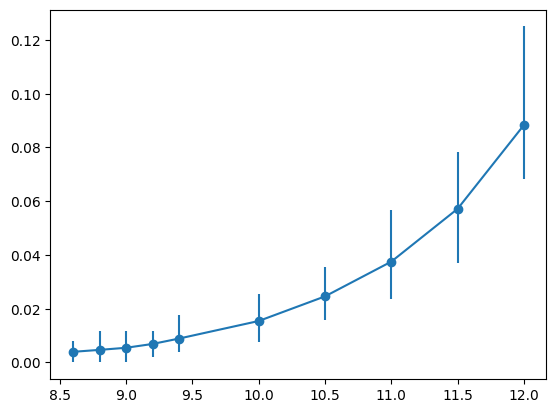

In [72]:
plt.errorbar(gses, error_rates, yerr=np.abs(np.array(error_rate_cis).T - error_rates), fmt='o-', label='Error Rate')

<ErrorbarContainer object of 3 artists>

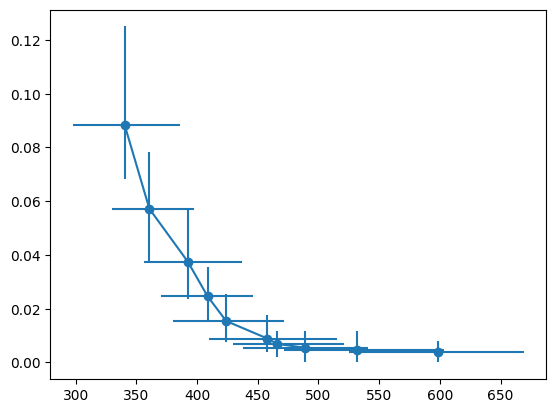

In [73]:
plt.errorbar(times, error_rates, yerr=np.abs(np.array(error_rate_cis).T - error_rates), xerr=np.abs(np.array(times_cis).T - times), fmt='o-', label='Error Rate')

In [55]:
np.percentile(error_rates, [5, 95])

array([0.00087891, 0.00976562])

In [76]:
system.g_se = 9.0
state = tileset.create_state() # make a new empty (except for seed) state
system.evolve(state, 
    show_window=True,     # show the UI
    initial_timescale=100, # lock timescale to be no more than 100x real time.
)

EvolveOutcome.ReachedTimeMax